In [1]:
import numpy as np
import pandas as pd
import csv
import keras
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples, homogeneity_completeness_v_measure
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

In [2]:
metric_names = ['Silhouette Coefficients ', 'Average Silhouette Metric ', 'Scaled Multiplied Silhouette Metric ']
radio_classes = [0, 1, 2, 3]
radio_names = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree']
scale = preprocessing.MinMaxScaler()

In [3]:
def cluster_centroid(embeddings, y_sc, numclusters):
    centroids = [] #center indice values
    for i in range(numclusters): #for each class...
        inds = np.where(y_sc==i)[0]#list of all images within the same proposed class
        print(inds)
        inds_embed = embeddings[inds] #feature vectors of all these images
        inds_embed1 = np.array(inds_embed) #numpy array of this matrix
        column_mean = inds_embed1.mean(axis=0) #mean per dimension (x, y, z, etc.)
        centroids.append(column_mean) #append to the list
    return centroids

In [4]:
def wss(centroids, embeddings, y_sc, numclusters, n): #in 2d - total wss (not average)
    wss_percluster = [] # list of total distance per class
    closest_inds = []
    farthest_inds = []
    for i in range(numclusters):
        inds = np.where(y_sc==i)[0] #list of all images within the same proposed class
        inds_embed = embeddings[inds] #feature vectors of all these images
        inds_embed1 = np.array(inds_embed) #numpy array of this matrix
        after_subtraction = inds_embed1 - centroids[i] #subtracting the centroid indices from the image indices
        squared_matrix = np.square(after_subtraction) #square the distance values
        sum_rows = np.sum(squared_matrix, axis = 1) #add all fo the distances of the same image 
        sum_cols = np.sum(sum_rows) #add all of image distances together of the same class 
        wss_percluster.append(sum_cols) #include this in the total distances per class
        ## find the images farthest/closest to centroid
        indclosest = np.argpartition(sum_rows, n)[:n]
        indfarthest = np.argpartition(sum_rows, -n)[-n:]
        indclosestnum = inds[indclosest]
        indfarthestnum = inds[indfarthest]
        closest_inds.append(indclosestnum)
        farthest_inds.append(indfarthestnum) #final image number
    tot_wss = np.sum(wss_percluster) #sum all of the distances from all of the clusters into 1 value 
    return tot_wss, closest_inds, farthest_inds

In [5]:
# Silhouette plot 
def silhouette_plt(y_sc, silhouette_vals, numclusters, indicator):
    cluster_labels = np.unique(y_sc)
    ax_lower, ax_upper = 0, 0
    cticks = []
    sil_plot = plt.figure()
    for i, k in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y_sc == k]
        c_silhouette_vals.sort()
        ax_upper += len(c_silhouette_vals)
        #color = plt.jet()
        plt.barh(range(ax_lower, ax_upper), c_silhouette_vals, height=1.0, 
                         edgecolor='none', color=colors[i])
        cticks.append((ax_lower + ax_upper) / 2)
        ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    plt.axvline(silhouette_avg, color="red", linestyle="--") 
    plt.yticks(cticks, cluster_labels)
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    if indicator == 0:
        str2 = 'Unscaled Silhouette Plot For {} Clusters'.format(numclusters)
        #name = 'test case {}/{} cluster/og silhouette plot'.format(run, numclusters)
    else:
        str2 = 'Min-Max Silhouette Plot For {} Clusters'.format(numclusters)
        #name = 'test case {}/{} cluster/minmax silhouette plot'.format(run, numclusters)
    plt.title(str2)
    plt.tight_layout()
    # plt.show()
    # sil_plot.savefig(name)
    return silhouette_avg

In [6]:
# Find the average silhouette number per cluster
def silhouette_cluster_average(y_sc, silhouette_values, numclusters):
    silhouette_clusters = [] 
    for i in range(numclusters):
        inds = np.where(y_sc==i)[0]
        avg_ind = sum(silhouette_values[inds])/len(inds) 
        silhouette_clusters.append(avg_ind)
    return silhouette_clusters

In [7]:
# Make the silhouette cluster an array corresponding to the image numbers
def silhouette_cluster_array(y_sc, silhouette_clusters):
    silhouette_cluster_arr = []
    for im in range(len(y_sc)):
        cat = y_sc[im]
        c = silhouette_clusters[cat]
        silhouette_cluster_arr.append(c)
    silhouette_cluster_arr = np.array(silhouette_cluster_arr)
    return silhouette_cluster_arr

In [8]:
colors = ['#1f77b4', '#ff7f0e', '#a52a2a','#2ca02c'] 
radio_colors = ['#e81005', '#f7c00a', '#364acf', '#568208']

In [9]:
df1 = pd.read_csv('/Users/amalalmansour/Downloads/MaxSlice_LIDC.csv')
df2 = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Malignancy/Agreement_Binary_Rating.csv')
#df2 = pd.read_csv('/Users/amalalmansour/Desktop/New_Images/Spiculation/Agreement_Binary_Rating.csv')
total_ids = df2['InstanceID']
spic_ids = df2['InstanceID'].tolist()
spic_tr_val = df2['Binary Rating'].tolist()
vis_tr_te = df2['Agreement'].tolist()

In [10]:
train_slices = pd.merge(df2['InstanceID'], df1)
display(train_slices)

,InstanceID,noduleID,DicomImage,FilePath,subtlety,internalStructure,calcification,sphericity,margin,lobulation,...,Correlation,Energy,Homogeneity,Entropy,x_3rdordermoment,Inversevariance,Sumaverage,Variance,Clustertendency,MaxProbability
0,4,1,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0001\1.3.6.1....,5,1,6,3,3,3,...,0.894,0.0003,0.0532,8.15,1290000,0.0223,661.0,143000,541000,0.0009
1,118,5,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,4,1,6,4,5,1,...,0.793,0.0018,0.0764,6.43,8600000,0.0392,565.0,137000,492000,0.0052
2,134,3,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,5,1,6,5,4,1,...,0.899,0.0004,0.0572,8.03,735000,0.0247,416.0,111000,420000,0.0010
3,143,4,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0003\1.3.6.1....,3,1,6,5,5,1,...,0.692,0.0027,0.0312,6.03,-469000,0.0107,420.0,98700,333000,0.0043
4,175,6,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-0004\1.3.6.1....,5,1,3,5,5,1,...,0.634,0.0076,0.0296,4.98,15500000,0.0097,403.0,200000,650000,0.0105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,40771,2655,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-1010\1.3.6.1....,3,1,6,2,5,1,...,0.662,0.0071,0.0334,5.05,12500000,0.0130,446.0,101000,334000,0.0090
1328,40780,2657,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-1011\1.3.6.1....,5,1,6,5,5,4,...,0.877,0.0005,0.0527,7.81,2250000,0.0229,496.0,130000,488000,0.0013
1329,40794,2656,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-1011\1.3.6.1....,5,1,6,3,2,4,...,0.799,0.0009,0.0405,7.15,-3460000,0.0130,530.0,75600,272000,0.0020
1330,40801,2658,present,C:\LIDC_FULL\LIDC-IDRI\LIDC-IDRI-1011\1.3.6.1....,5,4,6,3,3,3,...,0.622,0.0007,0.0403,7.44,208000,0.0176,386.0,91200,296000,0.0018


In [11]:
numeric_feature_names = ['Area', 'ConvexArea', 'Perimeter', 'ConvexPerimeter', 'EquivDiameter',
                         'MajorAxisLength', 'MinorAxisLength',
                         'Elongation', 'Compactness', 'Eccentricity', 'Solidity', 'Extent',
                         'Circularity', 'RadialDistanceSD', 'SecondMoment', 'Roughness', 'MinIntensity',
                         'MaxIntensity', 'MeanIntensity', 'SDIntensity', 'MinIntensityBG',
                         'MaxIntensityBG', 'MeanIntensityBG', 'SDIntensityBG',
                         'IntensityDifference', 'markov1', 'markov2', 'markov3', 'markov4',
                         'markov5', 'gabormean_0_0', 'gaborSD_0_0', 'gabormean_0_1',
                         'gaborSD_0_1', 'gabormean_0_2', 'gaborSD_0_2', 'gabormean_1_0',
                         'gaborSD_1_0', 'gabormean_1_1', 'gaborSD_1_1', 'gabormean_1_2',
                         'gaborSD_1_2', 'gabormean_2_0', 'gaborSD_2_0', 'gabormean_2_1',
                         'gaborSD_2_1', 'gabormean_2_2', 'gaborSD_2_2', 'gabormean_3_0',
                         'gaborSD_3_0', 'gabormean_3_1', 'gaborSD_3_1', 'gabormean_3_2',
                         'gaborSD_3_2', 'Contrast', 'Correlation', 'Energy', 'Homogeneity',
                         'Entropy', 'x_3rdordermoment', 'Inversevariance', 'Sumaverage',
                         'Variance', 'Clustertendency']

In [12]:
df_feature = train_slices[numeric_feature_names]
df_feature = np.array(df_feature)
df_feature.shape

(1332, 64)

In [13]:
##### Import Trained Model #####
model = keras.models.load_model("/Users/amalalmansour/Desktop/New_Images/Malignancy/NN/NN_model_All" , compile = True)
#model = keras.models.load_model("/Users/amalalmansour/Desktop/New_Images/Spiculation/NN/NN_model_All" , compile = True)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 36)                2340      
                                                                 
 dense_1 (Dense)             (None, 3)                 111       
                                                                 
Total params: 2,451
Trainable params: 2,451
Non-trainable params: 0
_________________________________________________________________


In [15]:
# get the embeddings
total_embeddings_before = model.predict(df_feature)
#total_embeddings2 = (total_embeddings_before[0] - total_embeddings_before[0].min()) / (total_embeddings_before[0].max() - total_embeddings_before[0].min())
total_embeddings2 = (total_embeddings_before - total_embeddings_before.min()) / (total_embeddings_before.max() - total_embeddings_before.min())
tot_embedded2 = TSNE(n_components=2,random_state=2).fit_transform(total_embeddings2)

/Users/amalalmansour/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/amalalmansour/miniforge3/envs/env_tensorflow/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [16]:
Bin_Rating = df2['Binary Rating']

(array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

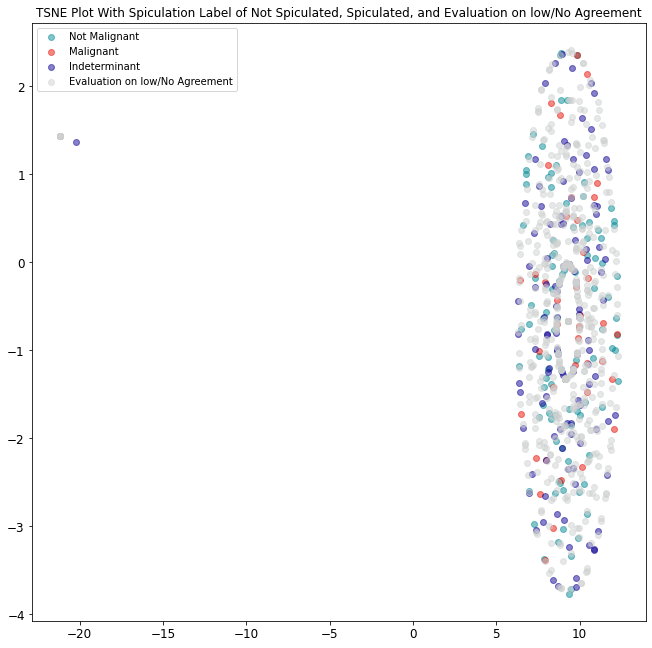

In [17]:
spic_tsne = plt.figure(figsize=(11,11))
#spic_classes = [0,1,2]
spic_classes = [0,1,2,3]
#spic_colors = ['#048a94','#e81005','#cfd1d1'] # RED, BLUE   # 1 = Spiculated, 0 = Not Spiculated
spic_colors = ['#048a94','#e81005', '#100494','#cfd1d1'] # RED, BLUE   # 1 = Spiculated, 0 = Not Spiculated
#spic_legend = ['Not Spiculated', 'Spiculated', 'Evaluation on low/No Agreement']
spic_legend = ['Not Malignant','Malignant', 'Indeterminant','Evaluation on low/No Agreement']

agreement_inds = []
agreement_id = []

for i in spic_classes:
    inds = np.where(Bin_Rating==i)
    plt.scatter(tot_embedded2[inds, 0], tot_embedded2[inds,1], alpha=0.5, color=spic_colors[i])
plt.title('TSNE Plot With Spiculation Label of Not Spiculated, Spiculated, and Evaluation on low/No Agreement')
#plt.title('TSNE Plot With Malignancy Label of Not Malignant Malignant Indeterminant and Evaluation on low/No Agreement')                                                         # commented out title
plt.legend(spic_legend, fontsize=10, loc=2)
ax = plt.gca()
leg = ax.get_legend()

leg.legendHandles[0].set_color('#048a94')
leg.legendHandles[1].set_color('#e81005')
leg.legendHandles[2].set_color('#100494')
leg.legendHandles[3].set_color('#cfd1d1')

#plt.legend(handles=scatter.legend_elements()[0], labels=spic_legend, fontsize=17, loc=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
#spic_tsne.savefig(name9, bbox_inches='tight')

(array([-5., -4., -3., -2., -1.,  0.,  1.,  2.,  3.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

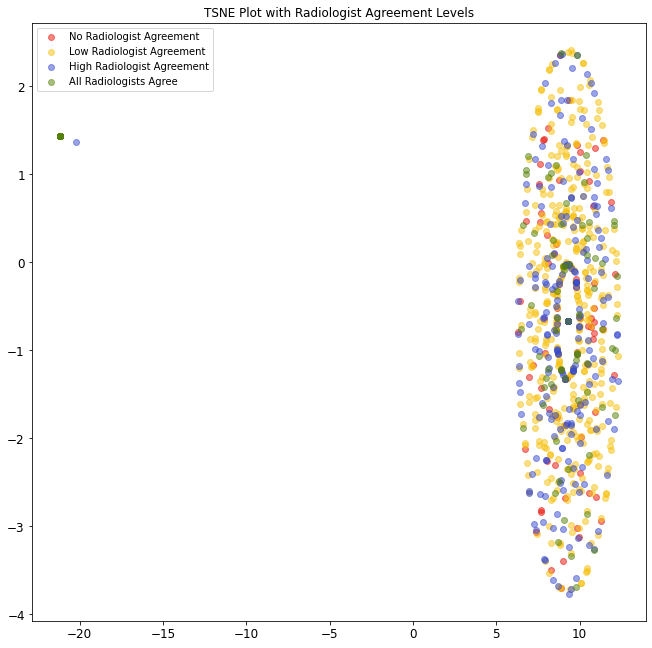

In [18]:
radio_ids = df2['InstanceID'] #pandas dataframe
radio_ids2 = radio_ids.values #list
agreements = df2['Agreement']
tsne_radio = plt.figure(figsize=(11,11))
radio_classes = [0, 1, 2, 3]
radio_names = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree']

agreement_inds = []
agreement_id = []

for i in radio_classes:
    inds = np.where(agreements==i)
    plt.scatter(tot_embedded2[inds, 0], tot_embedded2[inds,1], alpha=0.5, color=radio_colors[i])
    ids = radio_ids2[inds]
    agreement_inds.append(inds)  # should be in the order of high agreement -> low agreement  # also, these are the index numbers
    agreement_id.append(ids)  # these are the instance id's
plt.title('TSNE Plot with Radiologist Agreement Levels')                                                                       # commented out title
#plt.title('(b)', fontweight="bold", fontsize=20, y=-0.1)
plt.legend(radio_names, fontsize=10, loc=2)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

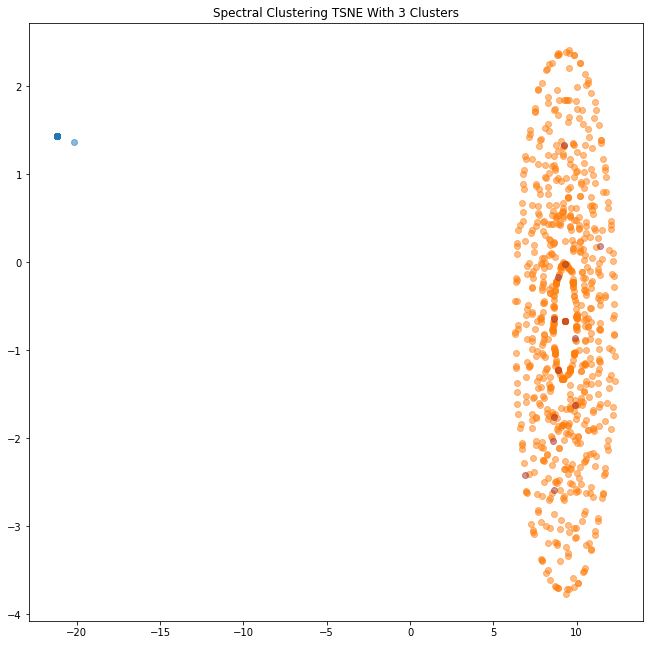

In [19]:
numbers = [3] #[2, 3, 4, 5, 6] #number of clusters
silhouette_total = []
wss_total = []
#spic_legend_Cls = ['Spiculated','Not Spiculated']
for numclusters in numbers:
    #embeddings = total_embeddings2 #change depending on if we wanna run test cases vs all cases
    X_embedded = tot_embedded2 #change depending on if we wanna run test cases vs all cases
    sc = SpectralClustering(n_clusters=numclusters, random_state=0) 
    y_sc = sc.fit_predict(total_embeddings2)

    # plot the tsne with spectral clusters
    og_spectral = plt.figure(figsize=(11,11))
    for i in range(numclusters):
        inds = np.where(y_sc==i)[0]
        plt.scatter(X_embedded[inds,0],X_embedded[inds,1],alpha=0.5, color=colors[i])
    #name3 = 'test case {}/{} cluster/spectral tsne'.format(run, numclusters)
    plt.title('Spectral Clustering TSNE With {} Clusters'.format(numclusters))

In [20]:
##### Data Analysis: WSS & Silhouette #####
# Calculate centroids and WSS
centroids = cluster_centroid(total_embeddings2, y_sc, numclusters)
wss_clusterlist, closest_ind_number, largest_ind_number = wss(centroids, total_embeddings2, y_sc, numclusters, 0) # only want the 0 highest and lowest points -- because the clusters are so small this is necessary for now
silhouette = silhouette_score(total_embeddings2, y_sc, metric = 'euclidean', random_state=9)
wss_total.append(wss_clusterlist) # for the wss elbow plot 
silhouette_total.append(silhouette) 

[   3    7    8   16   17   23   25   30   31   34   36   37   39   40
   45   48   53   54   57   66   68   73   78   81   90   92   99  102
  103  105  106  110  113  115  118  124  128  132  136  137  139  141
  142  144  151  153  158  161  163  165  166  169  185  188  191  197
  198  205  207  208  218  221  222  223  225  229  235  236  241  245
  246  247  250  251  258  261  266  267  268  269  272  280  290  292
  297  302  307  308  310  312  313  320  321  325  326  332  334  336
  338  340  348  358  360  361  362  364  368  371  382  383  386  389
  390  395  401  405  416  419  420  426  435  436  442  444  445  451
  455  459  461  462  465  470  471  472  482  487  488  491  492  500
  501  502  506  507  510  513  520  522  531  543  550  551  552  553
  556  558  564  565  569  570  572  573  575  580  581  587  590  595
  597  602  606  607  610  611  613  615  619  624  625  628  631  632
  633  634  635  636  637  639  642  644  645  646  647  650  651  652
  654 

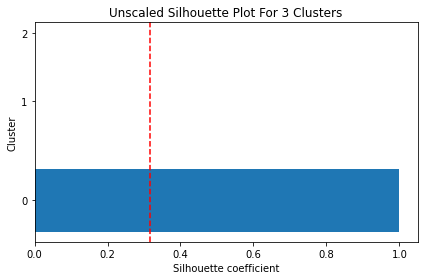

In [21]:
# First, do all silhouette work on the raw embeddings
silhouette_valsb4 = silhouette_samples(total_embeddings2, y_sc, metric='euclidean') # get the silhouette value per sample
silhouette_avgb4 = silhouette_plt(y_sc, silhouette_valsb4, numclusters, 0) # create and save the silhouette plot, and find the average of all of the silhouette scores
silhouette_clustersb4 = silhouette_cluster_average(y_sc, silhouette_valsb4, numclusters)
sil_clusterb4_avg = np.mean(silhouette_clustersb4) # average all of the averaged silhouette cluster scores
stdclustersb4 = np.std(silhouette_clustersb4) # find the standard deviation of the averaged silhouette cluster scores
sil_clus_arrayb4 = silhouette_cluster_array(y_sc, silhouette_clustersb4) # make the silhouette cluster an array corresponding to the image numbers

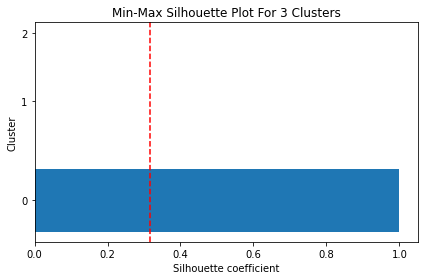

In [22]:
# Min Max all of the silhouette values, then repeat 
scaler = MinMaxScaler()
silhouette_vals = scaler.fit_transform(silhouette_valsb4.reshape(-1,1))
silhouette_vals = silhouette_vals.flatten()
sil_avg_minmax = silhouette_plt(y_sc, silhouette_vals, numclusters, 1)
silhouette_clusters = silhouette_cluster_average(y_sc, silhouette_vals, numclusters)
sil_cluster_avg = np.mean(silhouette_clusters)
stdclusters = np.std(silhouette_clusters)  
sil_clus_array = silhouette_cluster_array(y_sc, silhouette_clusters)

In [23]:
# Apply the reverse metric to the silhouette coefficients 
rev_silhouette_vals = silhouette_vals  
actual_silhouette_vals = 1 - silhouette_vals

# Take the average of the scaled silhouette values
scaler = MinMaxScaler() 
ci_avg = 1 - np.array([np.mean(k) for k in zip(silhouette_vals, sil_clus_array)])  ##  < to switch the metric backwards
ci_avg2 = np.array([np.mean(k) for k in zip(silhouette_vals, sil_clus_array)])  ## < for original metric (comparable to KNN)

# Multiply the scaled silhouette values
ci = 1 - (np.multiply(silhouette_vals, sil_clus_array))  ##  < to switch the metric backwards
ci_norm = scaler.fit_transform(ci.reshape(-1,1)) #< min max the confidence interval values
ci_norm = ci_norm.reshape(len(y_sc))
ci2 = np.multiply(silhouette_vals, sil_clus_array)  ##  < for original metric (comparable to KNN)
ci2_norm = scaler.fit_transform(ci2.reshape(-1,1)) #< min max the confidence interval values
ci2_norm = ci2_norm.reshape(len(y_sc))

In [24]:
# Save histograms for the metrics
def save_hist(data, numclusters):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.hist(data, color="black")
    ax.set_title('Silhouette Coefficients Histogram')
    ax.set_xlabel('Silhouette Coefficients Values')
    ax.set_ylabel('Frequency')
    #ax.set_xticks(minor=False)
    fig.tight_layout()
    #fig.savefig("test case {}/{} cluster/Histogram - {}.png".format(run, numclusters, filename), format='png')
    plt.show(fig)

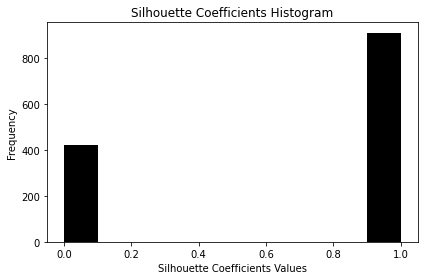

In [25]:
## Plot histograms for the metrics 
list_of_metrics = [ci_norm]       
#list_of_metrics = [actual_silhouette_vals, ci_avg, ci_norm]  
for q in range(len(list_of_metrics)):
    save_hist(list_of_metrics[q], numclusters)

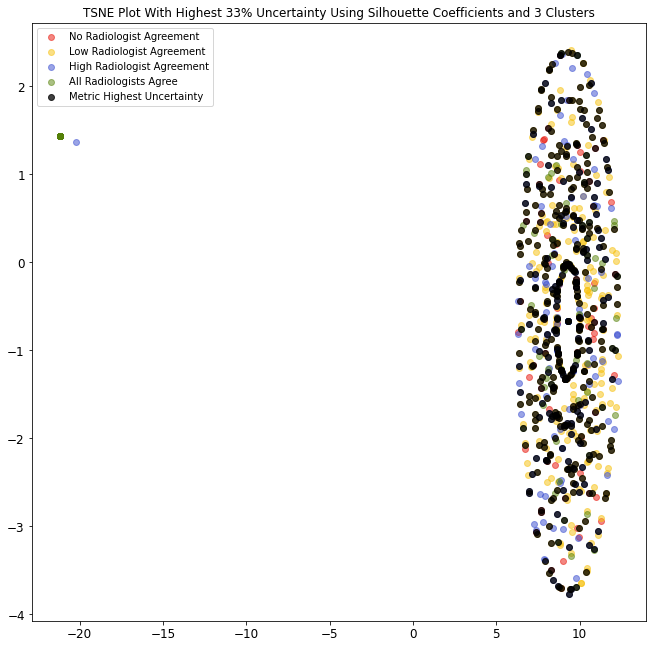

In [26]:
for m in range(len(list_of_metrics)):
    newlegend = ['No Radiologist Agreement', 'Low Radiologist Agreement', 'High Radiologist Agreement', 'All Radiologists Agree', 'Metric Highest Uncertainty']
    newlistnum = [441] #33% #[353, 706] #25%, 50%
    for r in newlistnum:
        indlargest = np.argpartition(list_of_metrics[m], -r)[-r:]
        new1 = plt.figure(figsize=(11,11))
        for i in radio_classes:
            inds = np.where(agreements==i)
            plt.scatter(tot_embedded2[inds, 0], tot_embedded2[inds,1], alpha=0.5, color=radio_colors[i]) 
        for k in indlargest:
            plt.scatter(tot_embedded2[k,0], tot_embedded2[k,1], alpha=0.75, color = 'black')
        title2 = 'TSNE Plot With Highest {}% Uncertainty Using {}and {} Clusters'.format(str(round(r/(len(y_sc))*100)), metric_names[m], numclusters)
        plt.title(title2)                                                                                                                              # commented out title    
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
        plt.legend(newlegend, fontsize=10, loc=2)
        plt.show()

In [27]:
ci_norm.max()

1.0

In [28]:
##### Highest Uncertainty Points #####
## obtain highest uncertainty indices 
unc_index = np.argpartition(ci_norm, -1332)[-1332:] 
unc_values = ci_norm[unc_index]
unc_ids = total_ids[unc_index]
unc_imgs = df_feature[unc_index]

# fix the agreement id variable to be iterable...
agreement_id2 = []
agreement_levels = []
counter = 0
for a in agreement_id:
    for k in a:
        agreement_id2.append(k)
        agreement_levels.append(counter)
    counter += 1

# retrieve vals for specific ids (highest uncertainty ids)
uncertainty_agreement = []
uncertainty_names = []

for k in unc_ids:
    agr_index = agreement_id2.index(k)
    unc_agr = agreement_levels[agr_index]
    unc_agr2= radio_names[unc_agr]

    uncertainty_agreement.append(unc_agr)
    uncertainty_names.append(unc_agr2)

######### ---Amal--- #########

## get spiculation rating for each image
spic_rate = []
instance_id = []
for j in unc_ids:
    if j in spic_ids:
        spic_index = spic_ids.index(j)
        spic_r = spic_tr_val[spic_index]
        spic_rate.append(spic_r)
        instance_id.append(j)

######### ---Amal--- #########


## print out each image
counter = 0

#To get uncertinaty scores for distrbution
num = []
agre = []
siz = []
spic = []
inst_id = []

for l in range(len(unc_imgs)):
    actual_unc = unc_values[l]
    num.append(actual_unc)
    unc_name = uncertainty_names[l]
    agre.append(unc_name)
    spic_unc = spic_rate[l]
    spic.append(spic_unc)
    id_inst = instance_id[l]
    inst_id.append(id_inst)

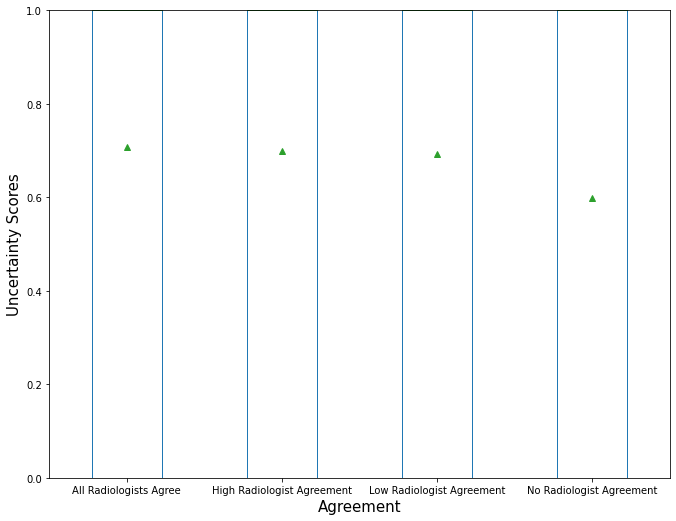

In [29]:
data = {'InstanceID': inst_id,
        'Score': num,
        'Agreement': agre,
        'Spiculation':spic}
        #'Category': cat_t}

# Convert the dictionary into DataFrame
df = pd.DataFrame(data)

plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))

axes = df.boxplot(by='Agreement',column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores", fontdict={'fontsize':15})
plt.xlabel("Agreement", fontdict={'fontsize':15})
plt.show()

In [30]:
m2 = df.groupby(['Agreement'])['Score'].mean().values
print(m2)

[0.70707071 0.69879518 0.69210174 0.5974026 ]


In [31]:
m1 = df.groupby(['Agreement'])['Score'].median().values
print(m1)

[1. 1. 1. 1.]


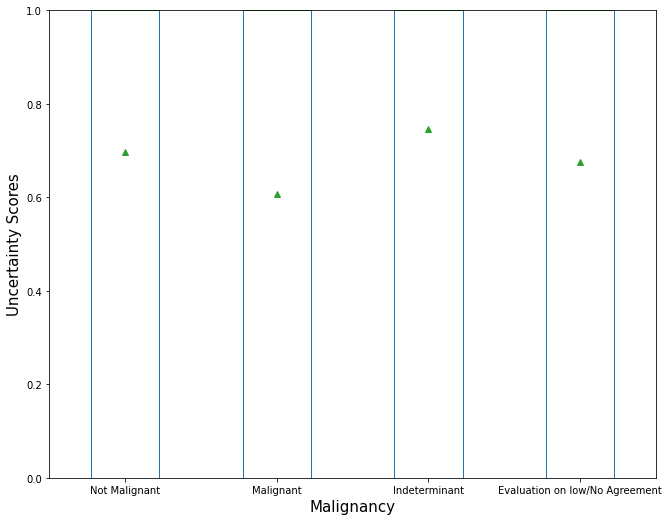

In [32]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))

axes = df.boxplot(by='Spiculation',column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores", fontdict={'fontsize':15})
plt.xlabel("Malignancy", fontdict={'fontsize':15})
#plt.xlabel("Spiculation", fontdict={'fontsize':15})
#plt.xticks([1, 2, 3], ['Not Spiculated', 'Spiculated', 'Evaluation on low/No Agreement'])
plt.xticks([1, 2, 3,4], ['Not Malignant','Malignant', 'Indeterminant','Evaluation on low/No Agreement'])
plt.show()

In [33]:
m1 = df.groupby(['Spiculation'])['Score'].mean().values
print(m1)

[0.69590643 0.60759494 0.74585635 0.67591565]


In [34]:
m1 = df.groupby(['Spiculation'])['Score'].median().values
print(m1)

[1. 1. 1. 1.]


([<matplotlib.axis.XTick at 0x17d18a670>,
 [Text(1, 0, 'Not Malignant\nAll Radiologists Agree'),
  Text(2, 0, 'Not Malignant\nHigh Radiologist Agreement'),
  Text(3, 0, 'Malignant\nAll Radiologists Agree'),
  Text(4, 0, 'Malignant\nHigh Radiologist Agreement'),
  Text(5, 0, 'Indeterminant\nAll Radiologists Agree'),
  Text(6, 0, 'Indeterminant\nHigh Radiologist Agreement'),
  Text(7, 0, 'Low Radiologist Agreement'),
  Text(8, 0, 'No Radiologist Agreement')])

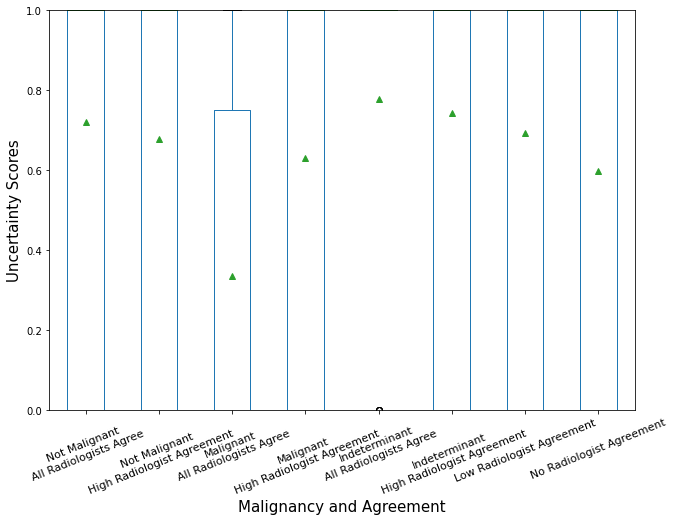

In [35]:
plt.rcParams["figure.figsize"] = [9.50, 7.50]
plt.rcParams["figure.autolayout"] = True
#df.plot(figsize=(20,20))
#newlegend1 = ['Not Malignant', 'Malignant','Indeterminant', 'Unknown']
axes = df.boxplot(by=['Spiculation','Agreement'], column =['Score'], showmeans=True, showfliers=True, grid= False)
axes.set_title('')
plt.title('')
plt.suptitle('')
plt.ylim([0.0, 1.0])
plt.ylabel("Uncertainty Scores",fontdict={'fontsize':15})
plt.xlabel("Malignancy and Agreement",fontdict={'fontsize':15})
#plt.xlabel("Spiculation and Agreement",fontdict={'fontsize':15})
#plt.xticks([1, 2, 3, 4,5,6], ["Not Spiculated\nAll Radiologists Agree", "Not Spiculated\nHigh Radiologist Agreement", "Spiculated\nAll Radiologists Agree", "Spiculated\nHigh Radiologist Agreement", "Evaluation on low Agreement", "Evaluation on No Agreement"], rotation=12, fontsize=10)
plt.xticks([1, 2, 3, 4,5,6,7,8], ["Not Malignant\nAll Radiologists Agree", "Not Malignant\nHigh Radiologist Agreement", "Malignant\nAll Radiologists Agree", "Malignant\nHigh Radiologist Agreement", "Indeterminant\nAll Radiologists Agree", "Indeterminant\nHigh Radiologist Agreement", "Low Radiologist Agreement", "No Radiologist Agreement"], rotation=22, fontsize=11)
#plt.xticks([1, 2, 3], ['Not Spiculated', 'Spiculated', 'Unknown'])

In [36]:
m1 = df.groupby(['Spiculation','Agreement'])['Score'].describe()
print(m1)

                                        count      mean       std  min  25%  \
Spiculation Agreement                                                         
0           All Radiologists Agree       75.0  0.720000  0.452022  0.0  0.0   
            High Radiologist Agreement   96.0  0.677083  0.470046  0.0  0.0   
1           All Radiologists Agree        6.0  0.333333  0.516398  0.0  0.0   
            High Radiologist Agreement   73.0  0.630137  0.486108  0.0  0.0   
2           All Radiologists Agree       18.0  0.777778  0.427793  0.0  1.0   
            High Radiologist Agreement  163.0  0.742331  0.438698  0.0  0.0   
3           Low Radiologist Agreement   747.0  0.692102  0.461934  0.0  0.0   
            No Radiologist Agreement    154.0  0.597403  0.492021  0.0  0.0   

                                        50%   75%  max  
Spiculation Agreement                                   
0           All Radiologists Agree      1.0  1.00  1.0  
            High Radiologist Agreement

In [37]:
m1 = df.groupby(['Spiculation','Agreement'])['Score'].median().values
print(m1)

[1. 1. 0. 1. 1. 1. 1. 1.]
